# Synthethic Dataset

### Creating a synthetic dataset of multi-digit images from the MNIST dataset 

---

This notebook explains my approach to creating a synthetic dataset of 64x64 images of digit sequences from the MNIST Handwritten Digit Database. The resulting dataset is fairly simple compared to the original SVHN dataset, but it allows us to quickly develop and experiment with model architectures for recognizing multiple digits in a single image.

Our resulting dataset consists of 50,000 greyscale images of size 64 x 64 where we have 10,000 examples for each possible sequence length. We randomly select the images that are concatenated from the original MNIST dataset. These images are then scaled down to 12 x 12 pixels (since 5 x 12 < 64) this allows us to fit up to 5 images horizontally. These images are then concatenated and centered both horizontally and vertically in the resulting image.

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 4.0)

/Users/thomasalm/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Loading the MNIST dataset

Let's load the MNIST dataset using the ``sklearn.datasets`` package for convinience.

In [2]:
from sklearn import datasets, preprocessing

# Fetch the MNIST dataset from mldata.org
mnist = datasets.fetch_mldata('MNIST original')

# Extract the data and labels
X, y = mnist.data.astype(float), mnist.target.astype(int)

print("Original Shape")
print(X.shape, y.shape)

# Reshape the original dataset which is flat to 28x28 images
X = X.reshape(len(X), 28, 28)

print("\nNew Shape")
print(X.shape)

Original Shape
((70000, 784), (70000,))

New Shape
(70000, 28, 28)


Let's implement a few helper functions to help us to visually explore our data.

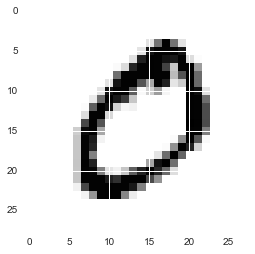

In [3]:
def plot_image(img):
    """Helper function for displaying a single image
    """
    plt.imshow(img, interpolation='nearest')

def plot_images(img, labels, nrows, ncols):
    """Helper function used to display digits
    """
    plt.figure(figsize=(min(16, ncols*2), min(16, nrows*2)))
    for i in range(nrows * ncols):
        plt.subplot(nrows, ncols, i+1)
        # Reshape every image to a square array 2d array
        if img[i].shape == (64, 64, 1):
            plt.imshow(img[i,:,:,0], interpolation='nearest')
        else:
            plt.imshow(img[i], interpolation='nearest')
        plt.xticks([]); plt.yticks([])
        plt.title(labels[i])
        

# Display a single image
plot_image(X[0])

Let's plot a few more digits to get a better sense of what the data looks like.

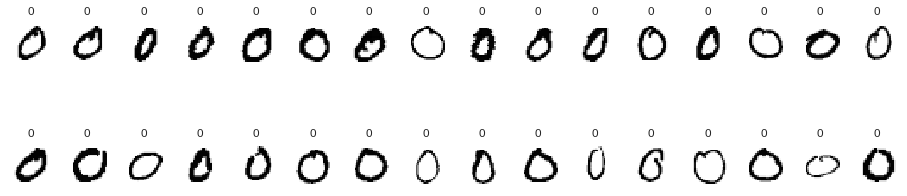

In [4]:
# Plot 2 rows with 16 digits each
plot_images(X, y, 2, 16)  

Looks like our dataset is ordered by label, let's randomly sort the arrays to view some of the other numbers as well

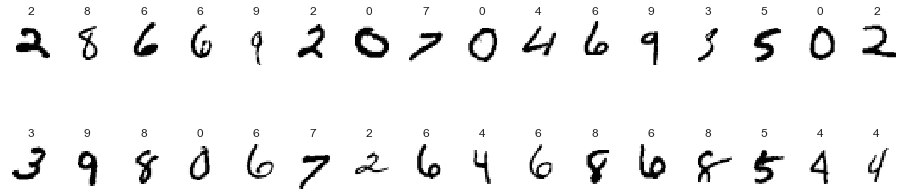

In [5]:
from sklearn.utils import shuffle

# Shuffle the dataset
X, y = shuffle(X, y)

# Plot 2 rows with 16 digits each
plot_images(X, y, 2, 16)

## Creating the synthetic dataset

Let's create a synthetic dataset consisting of sequences of up to 5 digits using the MNIST dataset. Let's start by specifying the new dimensions, the maximum number of digits and the size of our new dataset for convenience.

In [6]:
# Height and width of our new synthethic images
height, width = 64, 64

# Maximum number of digits
max_digits = 5

# Scale the origina images down to 45% (12x12 pixels)
scale = 0.45

# New height and width of the scaled images
new_height, new_width = 12, 12

# We create a new dataset with 50,000 images
dataset_size = 50000

### Concatenating the images and labels

Here is a simple function to concatenate a set of images into a single larger image and center the digit sequence within the new image. The following bulletpoints outline the procedure:

* By scaling the image to 45% we get a 12 x 12 image
* If we concatenate, say 3 images our resulting image will be 12 x 36 pixels
* To center this image horizontally we must calculate the padding on each side, which is (64 - 36) / 2 = 14
* To center it vertically we know that our new image is 64 pixels high and that our scaled images are 12 x 12 pixels. This means that we must pad the image with (64 - 12) / 2 = 26 pixels vertically.

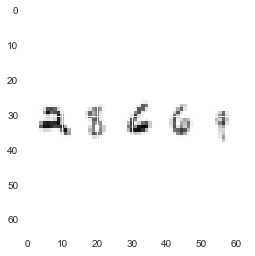

In [7]:
from scipy.misc import imresize

def concat_images(images):
    """ Scales, concatenates and centers a sequence of digits in an image
    """
    # Keep this
    num_digits = len(images)    
    
    # Initialize a numpy array for the new image
    new_image = np.zeros(shape=(height, width), dtype="uint8")
    
    # Calculate the horizontal and vertical padding
    y_pad = (height - new_height) / 2
    x_pad = (width - num_digits * new_width) / 2
    
    # For every image passed to the function
    for i in range(num_digits):
                         
        # Scale down the original image
        scaled = imresize(images[i], scale)
        
        # Calculate the starting position
        x_offset = x_pad + (i*new_width)
        
        # Add the scaled image to the new image
        new_image[y_pad:height-y_pad, x_offset:x_offset+new_width] = scaled
        
    # Return the newly centered image
    return new_image


# Concatenate image 0 through 5 to a single image
plot_image(concat_images(X[0:5]))

We also need a new label structure for our newly created images. Let's represent each label as a list where each element represents the digit in the sequence. For sequences with less than 5 digits we use 10 as a filler to represent missing values.

In [8]:
def concat_labels(labels, num_images=5):
    """ Concatenates a set of set of labels into a single numpy array
    """
    new_label = np.zeros(num_images, dtype=int)
    for i in range(num_images):
        if i < len(labels):
            new_label[i] = labels[i]
        else:
            new_label[i] = 10
    return new_label


# Concatenate the labels for image 0 through 5
concat_labels(y[:5])

array([2, 8, 6, 6, 9])

Let's test the function to see that we are able to generate some images with different number of digits and that our new labels match the images

array([2, 8, 6, 6, 9])

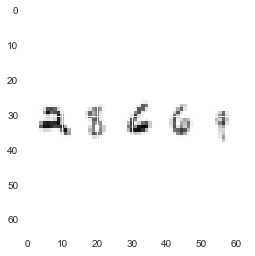

In [9]:
# Display images 0 through 5
plot_image(concat_images(X[:5]))

# Print the label for the new image
concat_labels(y[:5])

array([ 2,  8,  6, 10, 10])

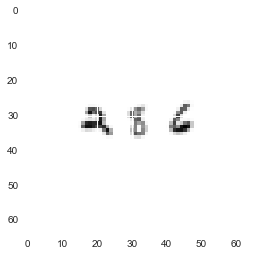

In [10]:
# Display images 0 through 3
plot_image(concat_images(X[:3]))

# Print the labels for the new image
concat_labels(y[:3])

array([ 2, 10, 10, 10, 10])

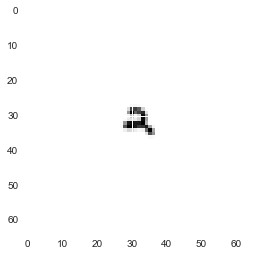

In [11]:
# Display the first image
plot_image(concat_images(X[:1]))

# Print the new label
concat_labels(y[:1])

### Dataset generator

Let's write a simple function that will help us to generate our synthetic dataset. The function will create an even number of samples for the different digit sequence length. E.g, if we want to create 50,000 images we will get 10,000 images with a single digit, 20,000 images with 2 digits etc.

In [12]:
import random

def generate_digit_sequences(data, labels, n):
    """ Helper function for automatically generating a new dataset of digit sequences
    """
    # Initialize numpy arrays
    X = np.zeros(shape=(n, height, width), dtype='uint8')
    y = np.zeros(shape=(n, max_digits), dtype=np.int32)
    
    # Number of training examples of each sequence length
    n_samples = n / max_digits
    
    # For every possible digit sequence length
    for i in range(1, max_digits+1):
        
        # Pick n_samples images
        for j in range((i-1)*n_samples, i*n_samples):
            
            # Select i random digits from the original dataset
            selection = random.sample(range(0, len(data)), i)
            
            # Concatenate the digits and labels from
            X[j] = concat_images(data[selection])
            y[j] = concat_labels(labels[selection])
            
    # Add an additional dimension to the image array
    X = np.expand_dims(X, axis=3)
            
    # Return the new dataset
    return X, y


# Generate a synthetic dataset of digit sequences with 50,000 new images
X_new, y_new = generate_digit_sequences(X, y, dataset_size)

print("Images", X_new.shape)
print("Labels", y_new.shape)

('Images', (50000, 64, 64, 1))
('Labels', (50000, 5))


#### Class Balance and sequence lengths

Let's verify that our dataset is fairly balanced in terms of the individual digits (0-9) and that we actually generated a dataset with an even distribution of digit sequence lengths.

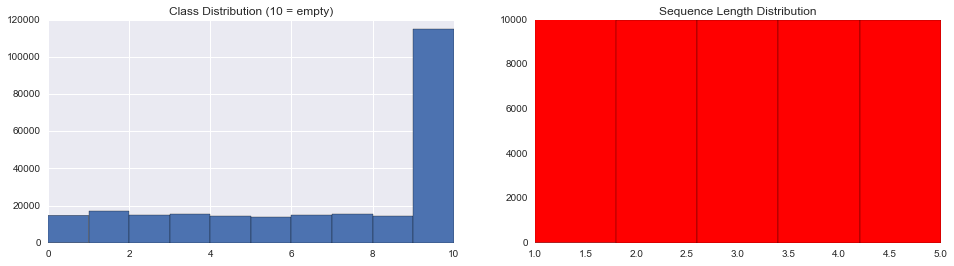

In [13]:
# Plot a histogram showing the class distribution
plt.subplot2grid((1, 2), (0, 0))
plt.hist(y_new.flatten())
plt.title("Class Distribution (10 = empty)")

# Plot a histogram showing the sequence length distribution
plt.subplot2grid((1, 2), (0, 1))
plt.hist((y_new != 10).sum(1), color='r', bins=5)
plt.xlim(1, 5)
plt.title("Sequence Length Distribution");

The histogram looks ok. As expected we have an overweight of 10's that are used to represent missing numbers.

### Sanity Check

Let's do a sanity check of our dataset to make sure that our images looks ok and that our labels match the images.

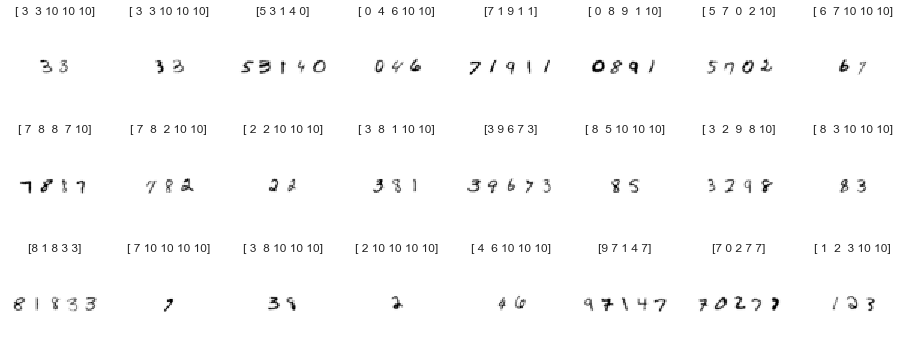

In [14]:
# Shuffle the examples before visualizing
X_new, y_new = shuffle(X_new, y_new, random_state=0)

# Plot 3 rows of 8 images from the new dataset
plot_images(X_new, y_new, 3, 8)

### Training, Test and Validation Sets

Let's split our dataset and create a training, test and validation set

In [15]:
from sklearn.cross_validation import train_test_split

# Create a training and test set
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new)

# Select some random images to be used in our validation set
idx = np.random.choice(range(0, len(X_test)), size=int(len(X_test)*0.20), replace=False)

# Construct our validation set and remove the images from the test set
X_val, y_val = X_test[idx], y_test[idx]

# Remove the validation samples from the testset
X_test = np.delete(X_test, idx, axis=0)
y_test = np.delete(y_test, idx, axis=0)

print("Training", X_train.shape, y_train.shape)
print("Test", X_test.shape, y_test.shape)
print('Validation', X_val.shape, y_val.shape)

('Training', (37500, 64, 64, 1), (37500, 5))
('Test', (10000, 64, 64, 1), (10000, 5))
('Validation', (2500, 64, 64, 1), (2500, 5))


## Storing the Data

Let's store our new datasets in a h5py file that we will use as model input.

In [16]:
import h5py

# Create file
h5f = h5py.File('data/MNIST_synthetic.h5', 'w')

# Store the datasets
h5f.create_dataset('train_dataset', data=X_train)
h5f.create_dataset('train_labels', data=y_train)
h5f.create_dataset('test_dataset', data=X_test)
h5f.create_dataset('test_labels', data=y_test)
h5f.create_dataset('valid_dataset', data=X_val)
h5f.create_dataset('valid_labels', data=y_val)

# Close the file
h5f.close()